In [1]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geone

from metrics import Loader
from metrics import crps_volume, crps_pointwise, abs_mean_volume, abs_mean_pointwise
from metrics import mean_JS_flow

In [2]:
CACHE_DIR = 'cache'
OUTPUT_DIR = 'output'
for directory in [CACHE_DIR, OUTPUT_DIR]:
    os.makedirs(directory, exist_ok=True)

## Load all available filenames

In [3]:
# get all filenames (pickles)
files = glob.glob('/home/nevena/data_tsanfleuron/**/*.pickle', recursive=True)
df = pd.DataFrame({'filename': files})
df.head(n=10)

,filename
0,/home/nevena/data_tsanfleuron/mps/simu_mps_par...
1,/home/nevena/data_tsanfleuron/mps/simu_mps_par...
2,/home/nevena/data_tsanfleuron/mps/simu_mps_par...
3,/home/nevena/data_tsanfleuron/mps/simu_mps_par...
4,/home/nevena/data_tsanfleuron/mps/simu_mps_par...
5,/home/nevena/data_tsanfleuron/mps/simu_mps_par...
6,/home/nevena/data_tsanfleuron/mps/simu_mps_par...
7,/home/nevena/data_tsanfleuron/mps/simu_mps_par...
8,/home/nevena/data_tsanfleuron/mps/simu_mps_par...
9,/home/nevena/data_tsanfleuron/mps/simu_mps_par...


In [4]:
df.count()['filename']

504

## Volume / poinwise scores based on topography

In [5]:
def evaluate_volume_estimation(row):
    """
    Computes volume and pointwise scores
    for each realisation and simulation method
    """
    loader = Loader(row['filename'])
    row['method'] = loader.method
    true_field = loader.get_true_dem()
    simulations = loader.get_simulated_dems()
    row['crps_volume'] =  crps_volume(true_field, simulations)
    row['avg_crps_pointwise'] = np.mean(crps_pointwise(true_field, simulations))
    row['abs_mean_volume'] = abs_mean_volume(true_field, simulations)
    row['avg_abs_mean_pointwise'] = np.mean(abs_mean_pointwise(true_field, simulations))
    return row

In [6]:
# Computes around an hour if vol_scores missing!
cached_vol_scores = f'{CACHE_DIR}/vol_scores.csv'
try:
    df_vol_scores = pd.read_csv(cached_vol_scores)
except FileNotFoundError:
    df_vol_scores = df.apply(lambda row: evaluate_volume_estimation(row), axis=1)
    df_vol_scores.to_csv(cached_vol_scores)

In [7]:
df_vol_scores.head()

,Unnamed: 0,filename,method,crps_volume,avg_crps_pointwise,abs_mean_volume,avg_abs_mean_pointwise
0,0,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,3.171009,4.819423,4.970144,7.129759
1,1,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.397015,2.700963,0.533916,3.545374
2,2,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,2.390637,3.758225,3.317214,5.215598
3,3,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,2.199690,3.294327,3.219313,4.672524
4,4,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.272500,3.031496,0.177027,4.175288


## Flow-based score

In [8]:
def evaluate_flow(row):
    """
    Computes mean JS between true flow and bunch of simulations
    for each realisation and simulation method
    """
    loader = Loader(row['filename'])
    true_flow = loader.get_true_flow()
    simulations = loader.get_simulated_flows()
    row['mean_JS_flow'] = mean_JS_flow(true_flow, simulations)
    return row

In [9]:
# All is gathered in the dataframe
# computes in couple of minutes if all_scores.csv missing
cached_all_scores = f'{CACHE_DIR}/all_scores.csv'
try:
    df_all_scores = pd.read_csv(cached_all_scores)
except FileNotFoundError:
    df_all_scores = df_vol_scores.apply(lambda row: evaluate_flow(row), axis=1)
    df_all_scores.to_csv(cached_all_scores)

In [10]:
df_all_scores.head()

,Unnamed: 0,filename,method,crps_volume,avg_crps_pointwise,abs_mean_volume,avg_abs_mean_pointwise,mean_JS_flow
0,0,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,3.171009,4.819423,4.970144,7.129759,0.013381
1,1,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.397015,2.700963,0.533916,3.545374,0.010023
2,2,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,2.390637,3.758225,3.317214,5.215598,0.014435
3,3,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,2.199690,3.294327,3.219313,4.672524,0.024779
4,4,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.272500,3.031496,0.177027,4.175288,0.013634


## Parse filenames

In [11]:
import re
def parse_filenames(row):
    name = row['filename']
    row['grad'] = 'grad' in name
    row['hill'] = 'hill' in name
    row['realization'] = int(re.search(r"real[^0-9]*(\d+).pickle", name).group(1))
    sgs_p = re.search(r"sgs_test_(\d+)", name)
    row['sgs_points'] = 0 if sgs_p is None else int(sgs_p.group(1))
    mps_p = re.search(r"mps_param_(\d+)", name)
    row['mps_param_set'] = 0 if mps_p is None else int(mps_p.group(1))
    return row

In [12]:
df_analyse = df_all_scores.apply(lambda row: parse_filenames(row), axis=1)

In [13]:
df_analyse[df_analyse['realization'] == 2].head(30)

,Unnamed: 0,filename,method,crps_volume,avg_crps_pointwise,abs_mean_volume,avg_abs_mean_pointwise,mean_JS_flow,grad,hill,realization,sgs_points,mps_param_set
4,4,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.272500,3.031496,0.177027,4.175288,0.013634,True,False,2,0,8
26,26,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.307064,2.994173,0.057156,4.135309,0.012842,False,True,2,0,8
52,52,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.132358,3.244992,0.152689,4.206400,0.018861,True,False,2,0,2
74,74,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.104895,3.337648,0.018119,4.297231,0.018382,False,True,2,0,2
100,100,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.200709,3.258272,0.085662,4.210115,0.017991,True,False,2,0,0
122,122,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.149453,3.238665,0.126991,4.168537,0.017306,False,True,2,0,0
148,148,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.200583,2.991914,0.159509,4.056661,0.013065,True,False,2,0,3
170,170,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.197309,3.115363,0.092893,4.167592,0.012511,False,True,2,0,3
196,196,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.262292,3.076972,0.226097,4.257254,0.013637,True,False,2,0,7
218,218,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.256109,2.997463,0.142532,4.143339,0.012823,False,True,2,0,7


In [14]:
## Remove realizations 0, 1, 5, 10 which have bad conditioning
to_delete = [0, 1, 5, 10]
df_analyse_drop = df_analyse[~df_analyse['realization'].isin(to_delete)]
df_analyse_drop.shape

(420, 13)

In [15]:
df_analyse = df_analyse_drop

## Look at one MPS parameter set and check variability of CRPS scores

In [16]:
df_analyse[(df_analyse['grad']==True) & (df_analyse['mps_param_set']==1)].sort_values(by='crps_volume')

,Unnamed: 0,filename,method,crps_volume,avg_crps_pointwise,abs_mean_volume,avg_abs_mean_pointwise,mean_JS_flow,grad,hill,realization,sgs_points,mps_param_set
340,340,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.116438,3.276728,0.188931,4.224579,0.018924,True,False,2,0,1
381,381,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.261147,3.195724,0.190006,4.262740,0.018325,True,False,6,0,1
365,365,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.284092,3.932023,0.407008,5.022158,0.017485,True,False,14,0,1
345,345,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.305432,2.931601,0.424636,3.830673,0.018550,True,False,8,0,1
359,359,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.321657,2.817320,0.565858,3.658160,0.016983,True,False,4,0,1
374,374,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.345244,2.987919,0.563479,3.884382,0.017614,True,False,3,0,1
347,347,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.411322,3.362180,0.679614,4.441783,0.016311,True,False,15,0,1
348,348,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.518437,4.086576,0.871452,5.202658,0.017893,True,False,22,0,1
366,366,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,0.531611,3.135392,0.834599,3.986198,0.021713,True,False,17,0,1
382,382,/home/nevena/data_tsanfleuron/mps/simu_mps_par...,mps,1.149480,4.054136,1.488067,5.099240,0.018554,True,False,19,0,1


CRPS scores range from 0.1 to 5 and standard deviation is huge ...
Let's examine the best and worst cases for MPS

In [17]:
best_mps = df_analyse[(df_analyse['grad']==True) & (df_analyse['mps_param_set']==1)].sort_values(by='crps_volume').iloc[0]
worst_mps = df_analyse[(df_analyse['grad']==True) & (df_analyse['mps_param_set']==1)].sort_values(by='crps_volume').iloc[-1]

In [18]:
def plot_true_and_simulation(row, i=0):
    loader = Loader(row['filename'])
    img_geone = loader.get_Img_true_dem()
    hd = loader.get_conditioning_points()
    vmin = np.min(img_geone.val)
    vmax = np.max(img_geone.val)
    plt.figure()
    geone.imgplot.drawImage2D(img_geone, cmap='magma', vmin=vmin, vmax=vmax, title='true DEM')
    plt.scatter(hd['cell_x'], hd['cell_y'], marker='.', s=1,
                edgecolors='white', linewidths=1) # add hard data points
    plt.figure()
    img_geone_sim = loader.get_Img_sim_dem(i)
    geone.imgplot.drawImage2D(img_geone_sim, cmap='magma', vmin=vmin, vmax=vmax, title=f'simulation {i} with {row["method"]}')
    plt.scatter(hd['cell_x'], hd['cell_y'], marker='.', s=1,
                edgecolors='white', linewidths=1) # add hard data points

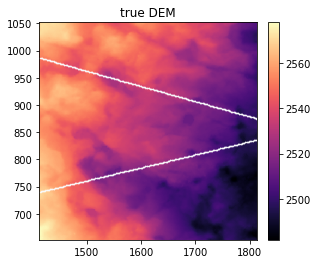

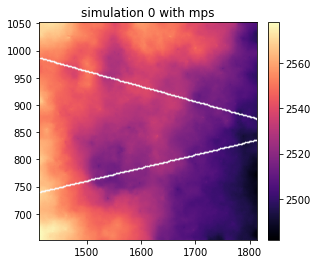

In [19]:
plot_true_and_simulation(best_mps)

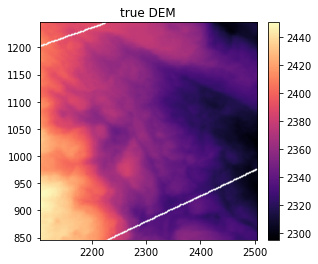

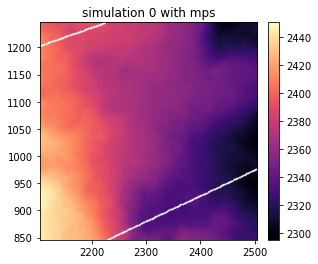

In [20]:
plot_true_and_simulation(worst_mps)

In [21]:
df_analyse[df_analyse.method == 'sgs']

,Unnamed: 0,filename,method,crps_volume,avg_crps_pointwise,abs_mean_volume,avg_abs_mean_pointwise,mean_JS_flow,grad,hill,realization,sgs_points,mps_param_set
456,456,/home/nevena/data_tsanfleuron/sgs/sgs_test_40_...,sgs,1.553466,4.466264,2.414255,6.124092,0.114781,False,False,14,40,0
457,457,/home/nevena/data_tsanfleuron/sgs/sgs_test_40_...,sgs,2.720641,4.800604,4.077398,6.359029,0.115863,False,False,9,40,0
458,458,/home/nevena/data_tsanfleuron/sgs/sgs_test_40_...,sgs,0.419859,3.306663,0.361556,4.297881,0.114666,False,False,8,40,0
459,459,/home/nevena/data_tsanfleuron/sgs/sgs_test_40_...,sgs,1.297963,3.613475,2.144859,4.481464,0.105712,False,False,16,40,0
460,460,/home/nevena/data_tsanfleuron/sgs/sgs_test_40_...,sgs,4.715913,4.750880,5.977219,6.863774,0.101593,False,False,21,40,0
461,461,/home/nevena/data_tsanfleuron/sgs/sgs_test_40_...,sgs,0.474449,3.898470,0.129577,5.204452,0.113888,False,False,22,40,0
462,462,/home/nevena/data_tsanfleuron/sgs/sgs_test_40_...,sgs,2.784658,4.368395,4.443999,5.816064,0.092415,False,False,6,40,0
464,464,/home/nevena/data_tsanfleuron/sgs/sgs_test_40_...,sgs,2.126944,3.867696,2.976864,5.221111,0.098368,False,False,20,40,0
465,465,/home/nevena/data_tsanfleuron/sgs/sgs_test_40_...,sgs,1.166603,3.388675,1.898318,4.184240,0.093304,False,False,4,40,0
466,466,/home/nevena/data_tsanfleuron/sgs/sgs_test_40_...,sgs,1.880404,3.754272,2.788830,4.820855,0.099437,False,False,3,40,0


In [22]:
best_sgs = df_analyse[(df_analyse['sgs_points']==24)].sort_values(by='crps_volume').iloc[0]
worst_sgs = df_analyse[(df_analyse['sgs_points']==24)].sort_values(by='crps_volume').iloc[-1]

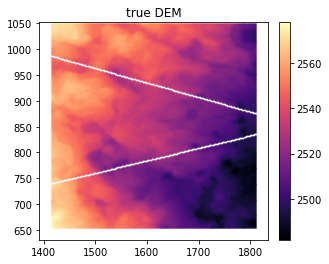

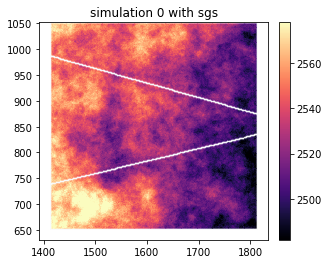

In [23]:
plot_true_and_simulation(best_sgs)

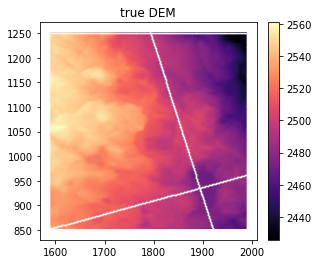

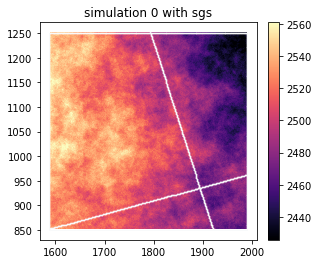

In [24]:
plot_true_and_simulation(worst_sgs)

In [25]:
best_krig = df_analyse[(df_analyse['method']=='krig')].sort_values(by='crps_volume').iloc[0]
worst_krig = df_analyse[(df_analyse['method']=='krig')].sort_values(by='crps_volume').iloc[-1]

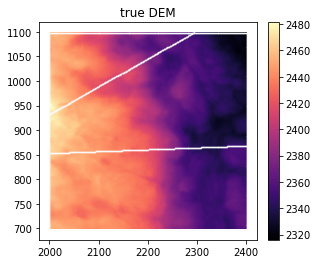

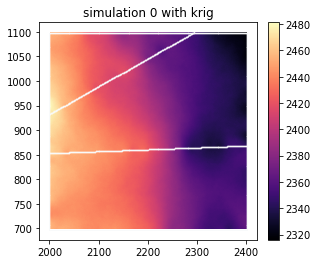

In [26]:
plot_true_and_simulation(best_krig)

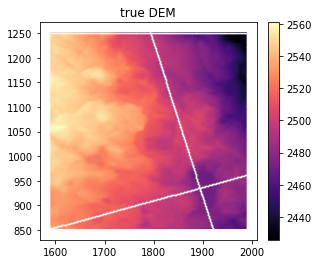

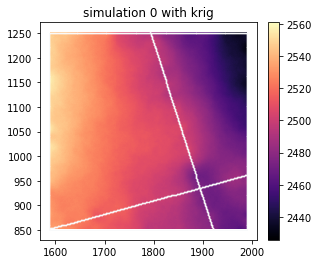

In [27]:
plot_true_and_simulation(worst_krig)

## Aggregate over realizations

In [28]:
# compare and include stds
df_compare_std = df_analyse.groupby(['method','grad', 'hill', 'sgs_points', 'mps_param_set']).agg({'mean_JS_flow' : [np.mean, np.std],
                                                                                        'crps_volume' : [np.mean, np.std],
                                                                                       }).reset_index()

# global comparison without std
df_compare = df_analyse.groupby(['method','grad', 'hill', 'sgs_points', 'mps_param_set']).agg({'mean_JS_flow' : np.mean,
                                                                                        'crps_volume' : np.mean,
                                                                                        'avg_crps_pointwise' : np.mean,
                                                                                        'abs_mean_volume' : np.mean,
                                                                                        'avg_abs_mean_pointwise' : np.mean,
                                                                                       }).reset_index()

In [29]:
df_compare_std.head(30)

method   grad   hill sgs_points mps_param_set mean_JS_flow            \
                                                         mean       std   
0    krig  False  False          0             0     0.047252  0.006306   
1     mps  False   True          0             0     0.016669  0.002828   
2     mps  False   True          0             1     0.017630  0.002916   
3     mps  False   True          0             2     0.017597  0.002888   
4     mps  False   True          0             3     0.012094  0.002569   
5     mps  False   True          0             4     0.012897  0.002588   
6     mps  False   True          0             5     0.012881  0.002610   
7     mps  False   True          0             6     0.013008  0.003135   
8     mps  False   True          0             7     0.013725  0.003080   
9     mps  False   True          0             8     0.013670  0.003074   
10    mps   True  False          0             0     0.017827  0.002714   
11    mps   True  False          0             1     0.018902  0.002827   
12    mps   True  False          0             2     0.018882  0.002875   
13    mps   True  False          0             3     0.013127  0.002531   
14    mps   True  False          0             4     0.014171  0.002641   
15    mps   True  False          0             5     0.014118  0.002650   
16    mps   True  False          0             6     0.013626  0.003071   
17    mps   True  False          0             7     0.014702  0.003200   
18    mps   True  False          0             8     0.014683  0.003251   
19    sgs  False  False         24             0     0.110515  0.010228   
20    sgs  False  False         40             0     0.108720  0.010142   

   crps_volume            
          mean       std  
0     2.910583  1.799162  
1     1.645016  1.578956  
2     1.710359  1.638619  
3     1.714139  1.616105  
4     1.541123  1.398399  
5     1.613779  1.491403  
6     1.609518  1.502168  
7     1.518501  1.386011  
8     1.436971  1.310113  
9     1.492761  1.403226  
10    1.620980  1.465056  
11    1.701706  1.581483  
12    1.696557  1.557116  
13    1.418069  1.273868  
14    1.611791  1.483210  
15    1.604735  1.433413  
16    1.412379  1.188869  
17    1.532452  1.263255  
18    1.467864  1.203030  
19    1.987406  1.277894  
20    1.972453  1.237382

In [30]:
df_paper = df_compare.sort_values(by='crps_volume')[df_compare.hill == False][['method',
                                                                               'mps_param_set',
                                                                               'crps_volume',
                                                                               'abs_mean_volume',
                                                                               'avg_crps_pointwise',
                                                                               'avg_abs_mean_pointwise',
                                                                               'mean_JS_flow']].set_index(['method', 'mps_param_set']).round({'crps_volume': 2,
                                                                                                                                             'abs_mean_volume':2,
                                                                                                                                             'avg_crps_pointwise':2,
                                                                                                                                             'avg_abs_mean_pointwise':2,
                                                                                                                                             'mean_JS_flow':3})
with open(f'{OUTPUT_DIR}/paper_table.tex', 'w') as file_handle:
    file_handle.write(df_paper.to_latex())

df_paper

/tmp/ipykernel_17522/4000487811.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_paper = df_compare.sort_values(by='crps_volume')[df_compare.hill == False][['method',


crps_volume  abs_mean_volume  avg_crps_pointwise  \
method mps_param_set                                                     
mps    6                     1.41             2.01                3.59   
       3                     1.42             1.91                3.66   
       8                     1.47             2.04                3.64   
       7                     1.53             2.11                3.68   
       5                     1.60             2.14                3.79   
       4                     1.61             2.11                3.79   
       0                     1.62             2.06                3.88   
       2                     1.70             2.11                3.95   
       1                     1.70             2.11                3.95   
sgs    0                     1.97             2.86                4.17   
       0                     1.99             2.96                4.18   
krig   0                     2.91             2.91                5.45   

                      avg_abs_mean_pointwise  mean_JS_flow  
method mps_param_set                                        
mps    6                                4.96         0.014  
       3                                4.92         0.013  
       8                                5.01         0.015  
       7                                5.07         0.015  
       5                                5.06         0.014  
       4                                5.06         0.014  
       0                                4.98         0.018  
       2                                5.05         0.019  
       1                                5.05         0.019  
sgs    0                                5.54         0.109  
       0                                5.61         0.111  
krig   0                                5.45         0.047

In [31]:
list(df_compare.columns)

['method',
 'grad',
 'hill',
 'sgs_points',
 'mps_param_set',
 'mean_JS_flow',
 'crps_volume',
 'avg_crps_pointwise',
 'abs_mean_volume',
 'avg_abs_mean_pointwise']

In [32]:
df_compare.sort_values(by='avg_crps_pointwise')

,method,grad,hill,sgs_points,mps_param_set,mean_JS_flow,crps_volume,avg_crps_pointwise,abs_mean_volume,avg_abs_mean_pointwise
16,mps,True,False,0,6,0.013626,1.412379,3.588336,2.014460,4.956999
7,mps,False,True,0,6,0.013008,1.518501,3.637127,2.148068,5.040423
18,mps,True,False,0,8,0.014683,1.467864,3.637234,2.039440,5.009282
8,mps,False,True,0,7,0.013725,1.436971,3.646405,2.074109,5.033663
9,mps,False,True,0,8,0.013670,1.492761,3.660902,2.142331,5.054411
13,mps,True,False,0,3,0.013127,1.418069,3.661532,1.905673,4.915219
17,mps,True,False,0,7,0.014702,1.532452,3.678376,2.111075,5.073418
4,mps,False,True,0,3,0.012094,1.541123,3.731606,2.034580,4.995793
6,mps,False,True,0,5,0.012881,1.609518,3.777846,2.143624,5.074324
5,mps,False,True,0,4,0.012897,1.613779,3.778152,2.157793,5.064973


In [33]:
df_compare.sort_values(by='abs_mean_volume')

,method,grad,hill,sgs_points,mps_param_set,mean_JS_flow,crps_volume,avg_crps_pointwise,abs_mean_volume,avg_abs_mean_pointwise
13,mps,True,False,0,3,0.013127,1.418069,3.661532,1.905673,4.915219
16,mps,True,False,0,6,0.013626,1.412379,3.588336,2.014460,4.956999
4,mps,False,True,0,3,0.012094,1.541123,3.731606,2.034580,4.995793
18,mps,True,False,0,8,0.014683,1.467864,3.637234,2.039440,5.009282
1,mps,False,True,0,0,0.016669,1.645016,3.908601,2.053675,4.990800
10,mps,True,False,0,0,0.017827,1.620980,3.883893,2.062247,4.981513
8,mps,False,True,0,7,0.013725,1.436971,3.646405,2.074109,5.033663
3,mps,False,True,0,2,0.017597,1.714139,3.966203,2.094309,5.060205
2,mps,False,True,0,1,0.017630,1.710359,3.953204,2.102359,5.057095
12,mps,True,False,0,2,0.018882,1.696557,3.945206,2.108696,5.047962


In [34]:
df_compare.sort_values(by='mean_JS_flow')

,method,grad,hill,sgs_points,mps_param_set,mean_JS_flow,crps_volume,avg_crps_pointwise,abs_mean_volume,avg_abs_mean_pointwise
4,mps,False,True,0,3,0.012094,1.541123,3.731606,2.034580,4.995793
6,mps,False,True,0,5,0.012881,1.609518,3.777846,2.143624,5.074324
5,mps,False,True,0,4,0.012897,1.613779,3.778152,2.157793,5.064973
7,mps,False,True,0,6,0.013008,1.518501,3.637127,2.148068,5.040423
13,mps,True,False,0,3,0.013127,1.418069,3.661532,1.905673,4.915219
16,mps,True,False,0,6,0.013626,1.412379,3.588336,2.014460,4.956999
9,mps,False,True,0,8,0.013670,1.492761,3.660902,2.142331,5.054411
8,mps,False,True,0,7,0.013725,1.436971,3.646405,2.074109,5.033663
15,mps,True,False,0,5,0.014118,1.604735,3.791889,2.139595,5.062824
14,mps,True,False,0,4,0.014171,1.611791,3.788351,2.114817,5.060086
